# Data Scientist Challenge

# Import the necessary libraries and modules

In [1]:
# Genenral and data manipulation
import os
import pickle
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Dataviz
import session_info
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('pastel')
sns.set_style('whitegrid')

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import (accuracy_score, 
                             precision_score,
                             recall_score, 
                             f1_score,)

# Load the data

## Sensors' data

### About the data
The file challenge_data.csv contains data collected by sensors in a rig during a tripping out operation. We expect that the data has a sample rate of 2 samples per second.

The file has the following columns:
* index: timestamp in ms
* BDEP: bit depth in m
* TPO: fluid flow in gpm
* HL: hook load in klbf
* BHT: block position in m
* RPM: rotary speed in rpm
* TOR: torque in klbf-ft
* DEPT: hole depth in m
* WOB: weight on bit in klbf

In [2]:
path = os.path.dirname(os.getcwd())
file = os.path.join(path, r'data\challenge_data.csv')
df = pd.read_csv(file, index_col=0)

# Converting the timestamp index to datetime
df.index = pd.to_datetime(df.index, unit='ms',)
# Sorting the data chronologically
df.sort_index(inplace=True)

print(f'The data contains {df.shape[0]} rows and {df.shape[1]} columns.')
df.head()

The data contains 40673 rows and 8 columns.


,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB
2020-12-05 01:12:00.313999872,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38
2020-12-05 01:12:00.822000128,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73
2020-12-05 01:12:01.328999936,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45
2020-12-05 01:12:01.838000128,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84
2020-12-05 01:12:02.345999872,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81


## Change points data

### About the data
The file challenge_annotation.csv contains annotated data on the classification change points, i.e., the timestamp of an 'off_slips' annotation marks the beggining of the 'off_slips' state, it remains unchanges until the timestamp of the next annotation.

The file has the following columns:
* index: timestamp in ms
* Annotation: annotations

In [3]:
file = os.path.join(path, r'data\challenge_annotation.csv')
target = pd.read_csv(file, index_col=0)

# Converting the timestamp index to datetime
target.index = pd.to_datetime(target.index, unit='ms',)
# Sorting the data chronologically
target.sort_index(inplace=True)

print(f'The data contains {target.shape[0]} rows and {target.shape[1]} columns.')
target.head()

The data contains 109 rows and 1 columns.


,Annotation
2020-12-05 01:14:22,off_slips
2020-12-05 01:14:40,on_slips
2020-12-05 01:16:06,off_slips
2020-12-05 01:20:06,on_slips
2020-12-05 01:21:37,off_slips


# Joining the change points to the sensors' data

Pandas has a function "merge_asof" that joins 2 dataframes by the nearest key rather than equals keys.

In [4]:
df1 = pd.merge_asof(left=df,
                    right=target,
                    left_index=True,
                    right_index=True,
                    direction='backward')

df1.head()

,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,Annotation
2020-12-05 01:12:00.313999872,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38,NaN
2020-12-05 01:12:00.822000128,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73,NaN
2020-12-05 01:12:01.328999936,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45,NaN
2020-12-05 01:12:01.838000128,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84,NaN
2020-12-05 01:12:02.345999872,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81,NaN


In [5]:
print(f"Amount of observations with nulls: {df1['Annotation'].isnull().sum()}")

Amount of observations with nulls: 284


## Dealing with missing targets

Looks like there are some observations with NaNs on the Annotation column when joining both dataframes. My intuition says that the reason is that the Annotations start slightly after the sensors' data. Let's assess:

In [6]:
print(f"The last null timestamp: {df1.loc[df1['Annotation'].isnull()].index.max()}")
print(f"The first annotation timestamp: {target.index.min()}")

The last null timestamp: 2020-12-05 01:14:21.855000064
The first annotation timestamp: 2020-12-05 01:14:22


Looks like in fact the sensors' data start a bit after the annotations but per the annotation data description we may assume that the missing data is the opposite of the first instance of the annotations data. The reason for that is "(...) marks the beginning of the state", so we may conclude that the previous state is the opposite.

In [7]:
target.head(1)

,Annotation
2020-12-05 01:14:22,off_slips


In [8]:
df1.loc[df1['Annotation'].isnull(), 'Annotation'] = 'on_slips'

## Spotting the transition points

This feature may help understand any patterns on the data

Since we don't have a perfect join between the dataset and the annotations, it's possible to spot the transitions by subtracting a row with the previous row after encoding the annotation to a number.

In [9]:
# Turning the target into numeric
df1['annotation_num'] = df1['Annotation'].map({'off_slips': 0, 'on_slips': 1})

# Subtracting the row with the previous
df1['diff'] = df1['annotation_num'].diff().fillna(0)
# Spotting the transitions (will be 1 and -1)
transitions = df1.loc[df1['diff'].isin([1, -1])].index
# Adding the transition column
df1['transition'] = 0
df1.loc[df1.index.isin(transitions), 'transition'] = 1
# dropping the diff 
df1.drop(columns=['diff'], inplace=True)

df1.head()

,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,Annotation,annotation_num,transition
2020-12-05 01:12:00.313999872,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38,on_slips,1,0
2020-12-05 01:12:00.822000128,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73,on_slips,1,0
2020-12-05 01:12:01.328999936,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45,on_slips,1,0
2020-12-05 01:12:01.838000128,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84,on_slips,1,0
2020-12-05 01:12:02.345999872,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81,on_slips,1,0


## Adding a time since last transition feature

This feature may help on the spotting of longer atypical periods on a single transition 

In [10]:
%%time
df1['time since last transition'] = np.nan
for i in range(len(transitions)):
    if not i:
        mask = df1.index < transitions[i]
    elif i < len(transitions) - 1:
        mask = (df1.index >= transitions[i - 1]) & (df1.index < transitions[i])
    else:
        mask = df1.index >= transitions[i]
    # Get the transition timestamp
    transition_time = df1.loc[mask].head(1).index[0] # Get the initial time
    # Add back to the original dataframe
    df1.loc[mask, 'time since last transition'] = (df1.loc[mask].index - transition_time).total_seconds()
    
df1.head()

Wall time: 108 ms


,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,Annotation,annotation_num,transition,time since last transition
2020-12-05 01:12:00.313999872,5063.135,19.548731,522.503986,18.982,0.0,0.0,5795.817,13.38,on_slips,1,0,0.000
2020-12-05 01:12:00.822000128,5063.135,15.586150,523.159986,19.068,0.0,0.0,5795.817,12.73,on_slips,1,0,0.508
2020-12-05 01:12:01.328999936,5062.959,18.492043,524.441986,19.164,0.0,0.0,5795.817,11.45,on_slips,1,0,1.015
2020-12-05 01:12:01.838000128,5062.959,16.114494,525.053986,19.249,0.0,0.0,5795.817,10.84,on_slips,1,0,1.524
2020-12-05 01:12:02.345999872,5062.778,17.699526,526.081986,19.347,0.0,0.0,5795.817,9.81,on_slips,1,0,2.032


In [11]:
df1.tail()

,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,Annotation,annotation_num,transition,time since last transition
2020-12-05 06:50:57.604,3055.453,0.0,358.541991,24.768,0.0,0.0,5795.817,2.46,off_slips,0,0,115.457
2020-12-05 06:50:58.112,3055.453,0.0,358.595991,24.856,0.0,0.0,5795.817,2.40,off_slips,0,0,115.965
2020-12-05 06:50:58.620,3055.453,0.0,358.605991,24.940,0.0,0.0,5795.817,2.39,off_slips,0,0,116.473
2020-12-05 06:50:59.128,3055.281,0.0,358.411991,25.038,0.0,0.0,5795.817,2.59,off_slips,0,0,116.981
2020-12-05 06:50:59.636,3055.281,0.0,357.757991,25.123,0.0,0.0,5795.817,3.24,off_slips,0,0,117.489


## Reorganizing the columns

In [12]:
predictors = list(df.columns)
new_vars = ['transition', 'time since last transition']
target = ['Annotation', 'annotation_num']
df1 = df1[predictors + new_vars + target]

# Exploratory data analysis

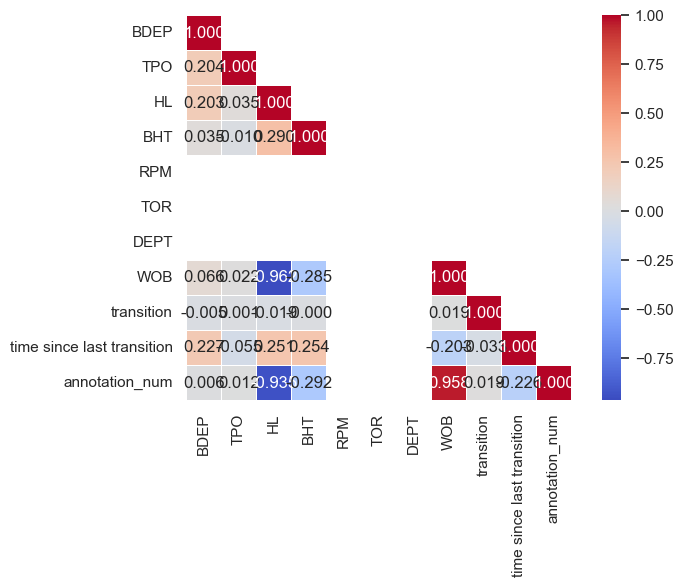

In [13]:
# Get correlations
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot the correlations
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, mask=mask, 
            cmap='coolwarm',
            annot=True, # Display numbers
            fmt='.3f', # Format of annotations 
            square=True, 
            linewidths=.5,)
plt.show()

Looks like some columns on the correlations dataframe have no data. The reason for that is because those features have the same value throughout the dataset. So we may exclude those features as they don't bring any additional insights to our analysis and model.

## Excluding features with one single value

In [14]:
# Creating a drop_features variable as it may come in hand when 
# creating a preprocessing pipeline 
drop_features = ['TOR', 'RPM', 'DEPT']
df1.drop(columns=drop_features, inplace=True, errors='ignore')

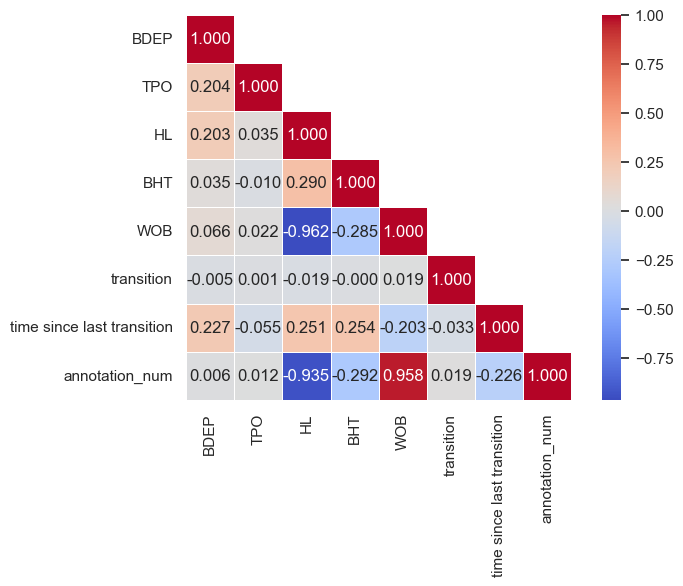

In [15]:
# Get correlations
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot the correlations
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, mask=mask, 
            cmap='coolwarm',
            annot=True, # Display numbers
            fmt='.3f', # Format of annotations 
            square=True, 
            linewidths=.5,)
plt.show()

**Predictor features**
- Looks like the variables Weight on bit (WOB) and hook load (HL) are highly correlated with the coefficient close to -1 meaning a strong negative correlation, i.e. the WOB decreases when the HL increases. This makes sense as the weight on bit increases the more pipe length it has been placed on top of it while the less load the hook needs to support. Highly correlated features may cause "multicollinearity" that happens when a predictor variable can be linearly predicted from others with high accuracy and may lead to misleading results. However, some models such as tree-based models and boosted trees are immune to this problem. But still it's a point to be accounted for.
- The weight on bit (WOB) and block position (BHT) are somewhat correlated but not too strong as the value -0.285 is not so close to -1 for a strong negative correlation.
- The block position (BHT) and the hook load (HL) are also a bit positively correlated but not as strong as the first observation.
- The hook load (HL) and bit depth (BDEP) are also a bit positively correlated but not as close to 1. 
- The rest of combinations of variables have a correlation close to 0 which means they are not strongly correlated.

**Target variable (Annotation)**
- It seems that both correlated variables hook load (HL) and weight on bit (WOB) are highly correlated to the target variable. When the weight on bit is loaded then there's a high chance that the slip is on.
- The block position (BHT) is also somewhat correlated to the annotation in a negative way meaning that when the slips is off (0) the block position increases.

## Histograms

### Bit depth (BDEP)

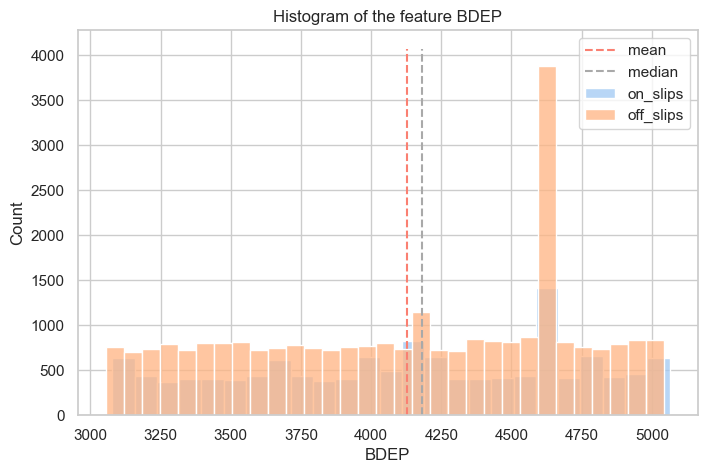

In [16]:
def plot_histogram(df, col, hue=None):
    """
    Plots a histogram from a dataframe for a given column.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Given dataframe with the data
    col : str
        The specified column to plot the 
    hue : str
        Column to split the histograms

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    if not hue:
        hist = sns.histplot(x=col, data=df, ax=ax)
    else:
        labels = df[hue].unique()
        colors = sns.color_palette()[:len(labels)]
        for h, c in zip(labels, colors):
            hist = sns.histplot(x=col, data=df[df[hue] == h], label=h, color=c, ax=ax)
    # Add mean
    mean = df[col].mean()
    y_min, y_max = hist.get_ylim()
    hist.vlines(mean, y_min, y_max, colors='salmon', linestyles='--', label='mean')
    # Add median
    median = df[col].median()
    hist.vlines(median, y_min, y_max, colors='darkgrey', linestyles='--', label='median')
    hist.legend()
    hist.set_title(f'Histogram of the feature {col}')
    plt.show()
    return None
    
plot_histogram(df1, 'BDEP', 'Annotation')

### Fluid flow (TPO)

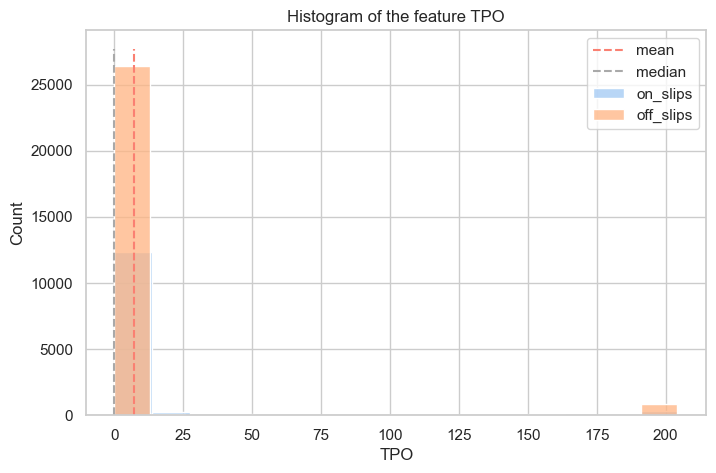

In [17]:
plot_histogram(df1, 'TPO', 'Annotation')

### Hook load (HL)

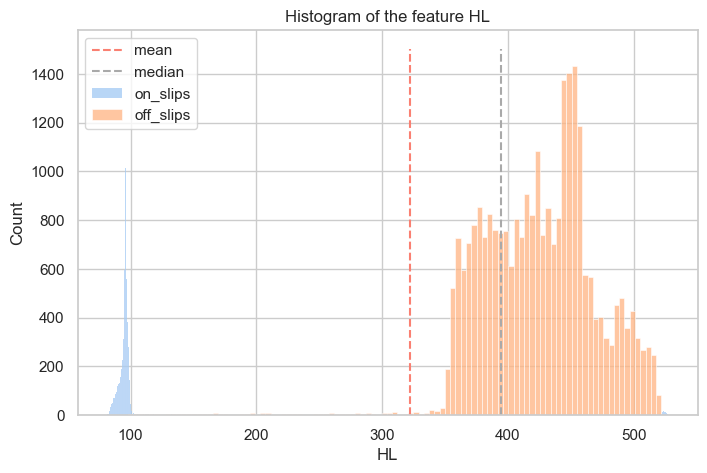

In [18]:
plot_histogram(df1, 'HL', 'Annotation')

### Block position (BHT)

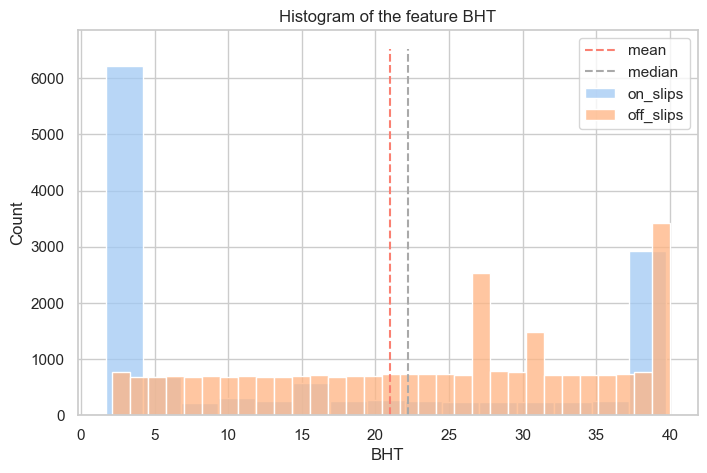

In [19]:
plot_histogram(df1, 'BHT', 'Annotation')

### Weight on bit (WOB)

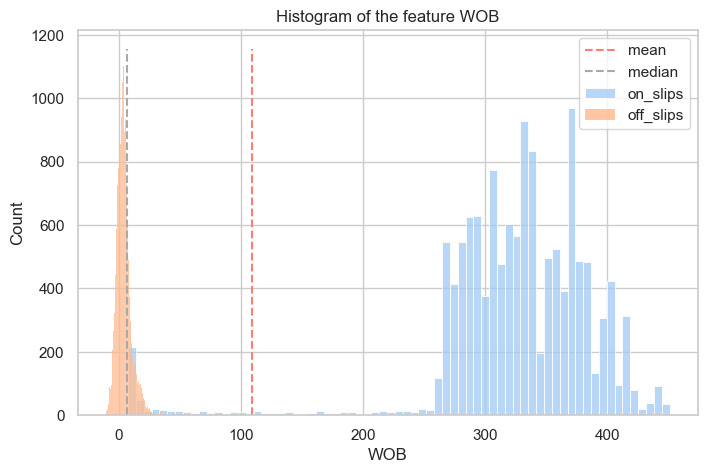

In [20]:
plot_histogram(df1, 'WOB', 'Annotation')

### Time since last transition

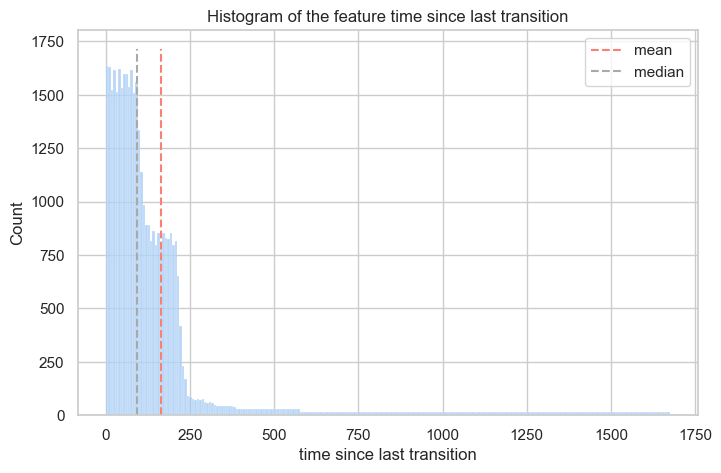

In [21]:
plot_histogram(df1, 'time since last transition')

From the histograms it seems that the most important columns to detect when the slips is on or off are the hook load (HL) and the weight on bit (BOT) which are strongly correlated between each other. The hook load increases when the slips is off and decreases when its on.

## Assessing seasonality

In [22]:
df1.head()

,BDEP,TPO,HL,BHT,WOB,transition,time since last transition,Annotation,annotation_num
2020-12-05 01:12:00.313999872,5063.135,19.548731,522.503986,18.982,13.38,0,0.000,on_slips,1
2020-12-05 01:12:00.822000128,5063.135,15.586150,523.159986,19.068,12.73,0,0.508,on_slips,1
2020-12-05 01:12:01.328999936,5062.959,18.492043,524.441986,19.164,11.45,0,1.015,on_slips,1
2020-12-05 01:12:01.838000128,5062.959,16.114494,525.053986,19.249,10.84,0,1.524,on_slips,1
2020-12-05 01:12:02.345999872,5062.778,17.699526,526.081986,19.347,9.81,0,2.032,on_slips,1


### Bit depth (BDEP)

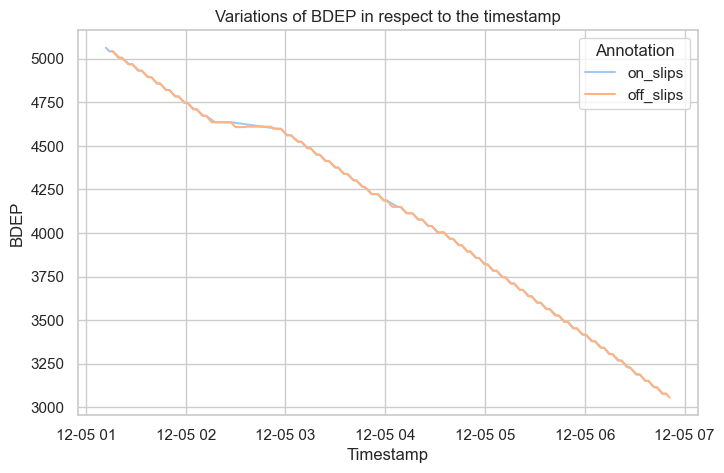

In [23]:
def plot_series(df, col, hue=None, timeseries_col=None):
    """
    Plots a timeseries line plot for the given column.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Given dataframe with the data
    col : str
        The specified column for the y-axis
    hue : str
        The column to split the lines to different classes
    timeseries_col : str optional
        The timeseries column
        If not specified the index column will be used

    Returns
    -------
    None
    """
    if not timeseries_col:
        timeseries_col = df.index
    fig, ax = plt.subplots(figsize=(8, 5))
    line = sns.lineplot(x=timeseries_col,
                        y=col,
                        hue=hue,
                        data=df,
                        ax=ax)
    line.set_xlabel('Timestamp')
    line.set_title(f'Variations of {col} in respect to the timestamp')
    plt.show()
    return None

plot_series(df1, 'BDEP', 'Annotation')

### Fluid flow (TPO)

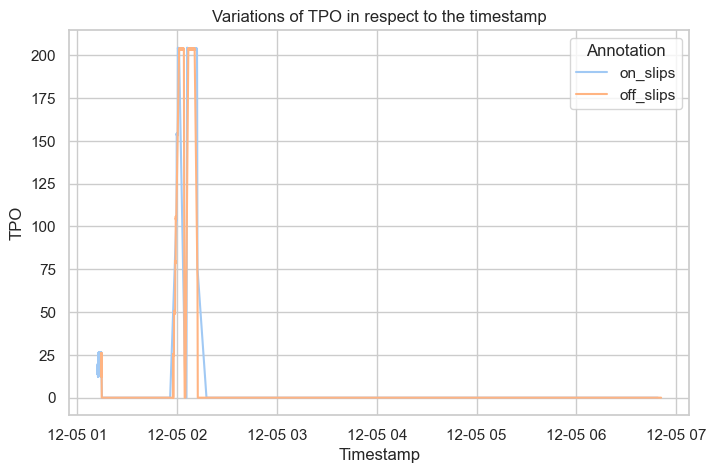

In [24]:
plot_series(df1, 'TPO', 'Annotation')

### Hook load (HL)

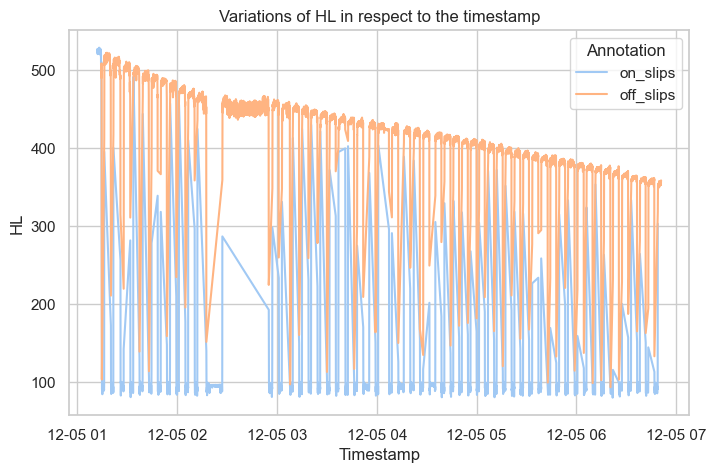

In [25]:
plot_series(df1, 'HL', 'Annotation')

### Block position (BHT)

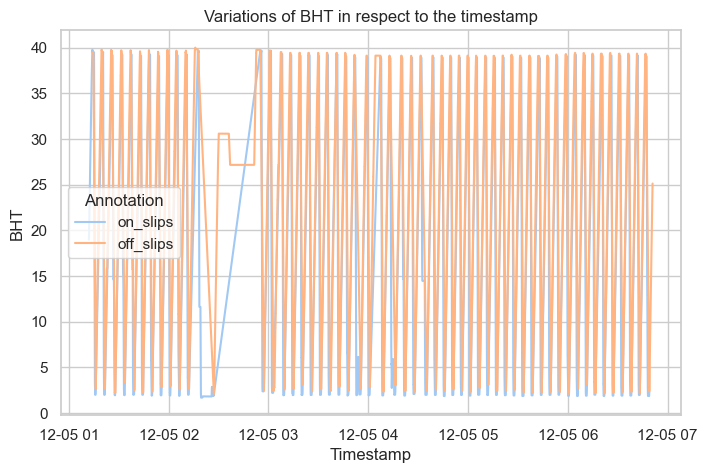

In [26]:
plot_series(df1, 'BHT', 'Annotation')

### Weight on bit (WOB)

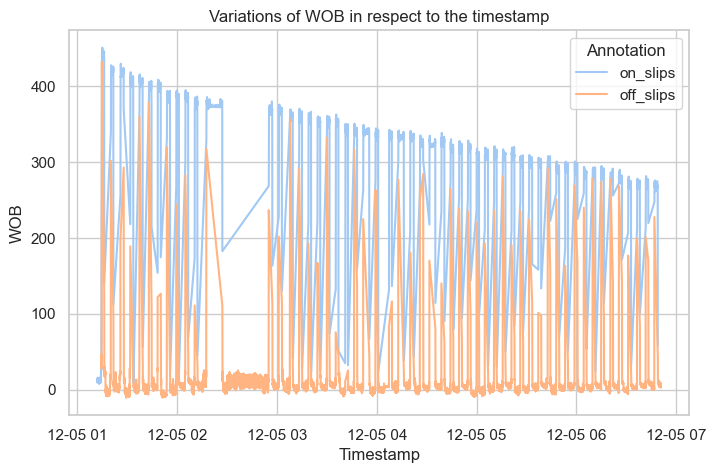

In [27]:
plot_series(df1, 'WOB', 'Annotation')

### time since last transition

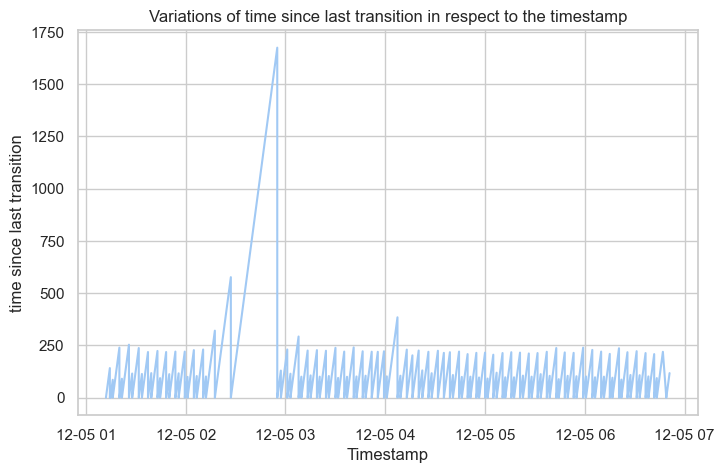

In [28]:
plot_series(df1, 'time since last transition')

In [29]:
slip_value = df1.loc[df1['time since last transition'] == df1['time since last transition'].max(), 'Annotation'].values[0]
print(f'The peak is {slip_value}.')

The peak is off_slips.


Looks like there's a peak on the data in which the slips remained off slips for a really long time. Seems to be an error of the sensors.

## Outliers

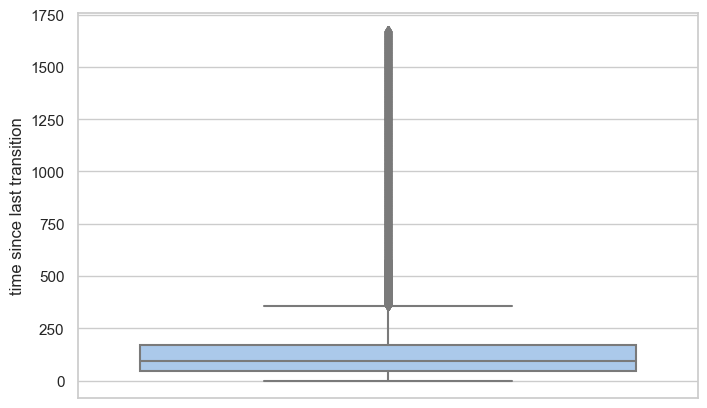

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
box = sns.boxplot(y='time since last transition', data=df1)
plt.show()

The boxplot is spotting a lot of outliers above the upper whisker. Let's add the whisker value to the timeseries plot to see if the cut would remove the abnormal peaks.

Instances above upper whisker: 3120


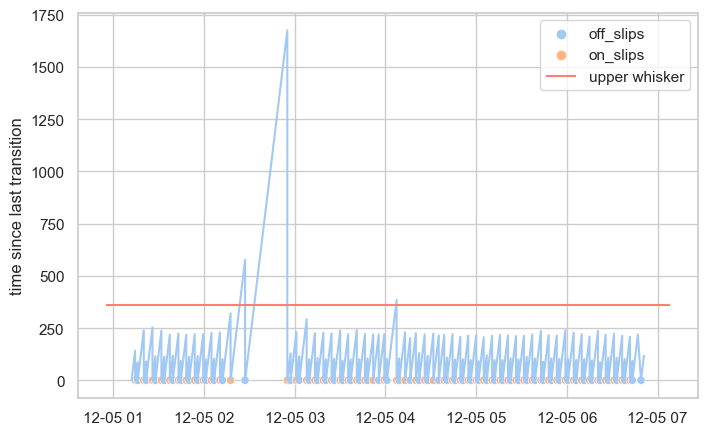

In [31]:
# Computing IQR
Q1 = df1['time since last transition'].quantile(0.25)
Q3 = df1['time since last transition'].quantile(0.75)
IQR = Q3 - Q1
UPPER = Q3 + 1.5 * IQR

print(f"Instances above upper whisker: {df1.loc[df1['time since last transition'] >= UPPER].shape[0]}")

fig, ax = plt.subplots(figsize=(8, 5))
line = sns.lineplot(x=df1.index, 
                     y='time since last transition',
                     data=df1, ax=ax)

# Plot the transitions as dots on the plot
transitions = df1.loc[df1['transition'] == 1].copy(deep=True)
scatter = sns.scatterplot(x=transitions.index,
                          y='time since last transition',
                          hue='Annotation',
                          data=transitions,
                          ax=ax)
xmin, xmax = line.get_xlim()
line.hlines(UPPER, xmin, xmax, color='salmon', label='upper whisker')
line.legend()
plt.show()

It seems that if we cut the data right above the upper whisker we should be able to prune the abnormal peaks.

### Removing outliers

In [32]:
size = df1.shape[0]
print(f'Orginial data size: {df1.shape[0]}')
df1 = df1.loc[df1['time since last transition'] <= UPPER]
print(f'Afer outliers removal: {df1.shape[0]} ({round(100*(1-df1.shape[0]/size), 1)}% reduction)')

Orginial data size: 40673
Afer outliers removal: 37307 (8.3% reduction)


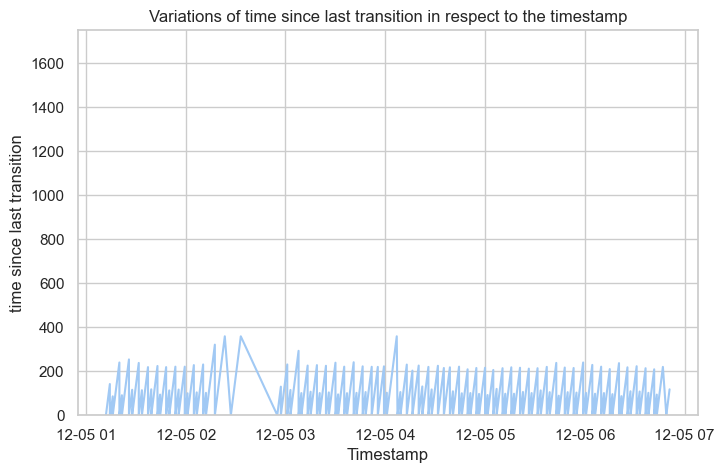

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
line = sns.lineplot(x=df1.index, 
                     y='time since last transition',
                     data=df1, ax=ax)
line.set_title('Variations of time since last transition in respect to the timestamp')
line.set_ylabel('time since last transition')
line.set_xlabel('Timestamp')
line.set_ylim(0, 1750) # Fixing the scale to compare to the previous plot
plt.show()

Looks good enough. The bigger space between 2 and 3h is due to the absence of data which has been removed on the outliers analysis. 

## Main outputs from the EAD

- The torque (TOR), rotary speed (RPM) and hole depth (DEPT) were excluded as they represent a single value feature, thus not helping the model at all.
- Both features hook load (HL) and weight on bit (WOB) are strongly correlated and the hook load increases when the slip is off and decreases when its on.
- Both features HL and WOB, which are correlated between each other, are strongly correlated to the slip position (on/off).

# Data preprocessing 

## Checking for missing values

In [34]:
nulls_df = pd.DataFrame(data=df1.isnull().sum(),
                        columns=['count'])
nulls_df['%'] = (100*nulls_df['count']/df.shape[0]).map('{:.1f}%'.format)
nulls_df

,count,%
BDEP,0,0.0%
TPO,9,0.0%
HL,0,0.0%
BHT,11,0.0%
WOB,16,0.0%
transition,0,0.0%
time since last transition,0,0.0%
Annotation,0,0.0%
annotation_num,0,0.0%


Looks like there are only a couple of missing values on the dataset. Let's dig into it.

In [35]:
nan_data = df1.loc[np.any(df1.isnull(), axis=1)].copy(deep=True)
nan_data['% of null'] = nan_data.isnull().sum(axis=1)/(nan_data.shape[1]-1)
nan_data

,BDEP,TPO,HL,BHT,WOB,transition,time since last transition,Annotation,annotation_num,% of null
2020-12-05 01:57:39.368000000,4761.827,0.0,483.163987,NaN,NaN,0,115.026,off_slips,0,0.250
2020-12-05 01:57:39.880000000,4761.827,0.0,482.213988,NaN,NaN,0,115.538,off_slips,0,0.250
2020-12-05 02:11:49.107000064,4672.719,NaN,93.847998,NaN,NaN,0,80.731,on_slips,1,0.375
2020-12-05 02:11:49.428000000,4672.719,NaN,93.685998,NaN,NaN,0,81.052,on_slips,1,0.375
2020-12-05 02:11:49.432000000,4672.719,NaN,93.563998,NaN,NaN,0,81.056,on_slips,1,0.375
2020-12-05 02:11:49.436000000,4672.719,NaN,94.417998,NaN,NaN,0,81.060,on_slips,1,0.375
2020-12-05 02:11:49.843000064,4672.719,NaN,94.595998,NaN,NaN,0,81.467,on_slips,1,0.375
2020-12-05 02:32:29.390000128,4606.822,NaN,445.253988,NaN,NaN,0,320.953,off_slips,0,0.375
2020-12-05 02:32:29.900999936,4606.822,NaN,447.383988,NaN,NaN,0,321.464,off_slips,0,0.375
2020-12-05 03:08:09.446000128,4523.872,0.0,94.787998,39.294,NaN,0,16.977,on_slips,1,0.125


The NaNs are within a couple of datapoints that have more than one feature missing. It seems to be a failure from the sensors, so we may drop those instances.

In [36]:
df1.dropna(axis=0, inplace=True)

### Checking for remaining NaNs

In [37]:
df1.isnull().sum()

BDEP                          0
TPO                           0
HL                            0
BHT                           0
WOB                           0
transition                    0
time since last transition    0
Annotation                    0
annotation_num                0
dtype: int64

## Checking for duplicated instances

From the problem in hand duplicated instances may occur. But duplicated measurements right next to each other may indicate a malfunction of the sensors to update the data collected. So the focus is to spot those instances, remove them and keep the duplicated values that aren't measures next to each other since it's a time-series so from a logical point of view the state may happen 2, 3 or more times during the whole process life.

In [38]:
dups = df1.loc[df1[['BDEP', 'TPO', 'HL', 'BHT', 'WOB', 'Annotation']].duplicated(keep=False)].copy(deep=True)
print(f'There are {dups.shape[0]} duplicated rows.')
dups.head()

There are 279 duplicated rows.


,BDEP,TPO,HL,BHT,WOB,transition,time since last transition,Annotation,annotation_num
2020-12-05 01:15:45.388000000,5042.746,0.0,95.969998,2.009,439.92,0,65.070,on_slips,1
2020-12-05 01:15:46.303000064,5042.746,0.0,95.969998,2.009,439.92,0,65.985,on_slips,1
2020-12-05 01:16:35.396000000,5036.768,0.0,512.627987,8.297,23.26,0,29.054,off_slips,0
2020-12-05 01:16:35.803000064,5036.768,0.0,512.627987,8.297,23.26,0,29.461,off_slips,0
2020-12-05 01:21:12.896999936,5005.673,0.0,96.173998,2.018,416.80,0,66.568,on_slips,1


In [39]:
df2 = df1.copy(deep=True)
df2['duplicated'] = 0
df2.loc[df2.index.isin(dups.index), 'duplicated'] = 1

# Using the diff method to spot duplicated values
# occouring next to each other
df2['row number'] = range(len(df2))
dups = df2.loc[df2['duplicated'] == 1].copy(deep=True)
dups['diff'] = dups['row number'].diff().fillna(2) # The first row is automatically kept

print(f"Duplicated values next to each other: {dups.loc[dups['diff'] == 1].shape[0]}")
print(f"Duplicated values apart from each other: {dups.loc[dups['diff'] > 1].shape[0]}")

Duplicated values next to each other: 73
Duplicated values apart from each other: 206


In [40]:
dups.head()

,BDEP,TPO,HL,BHT,WOB,transition,time since last transition,Annotation,annotation_num,duplicated,row number,diff
2020-12-05 01:15:45.388000000,5042.746,0.0,95.969998,2.009,439.92,0,65.070,on_slips,1,1,450,2.0
2020-12-05 01:15:46.303000064,5042.746,0.0,95.969998,2.009,439.92,0,65.985,on_slips,1,1,452,2.0
2020-12-05 01:16:35.396000000,5036.768,0.0,512.627987,8.297,23.26,0,29.054,off_slips,0,1,550,98.0
2020-12-05 01:16:35.803000064,5036.768,0.0,512.627987,8.297,23.26,0,29.461,off_slips,0,1,551,1.0
2020-12-05 01:21:12.896999936,5005.673,0.0,96.173998,2.018,416.80,0,66.568,on_slips,1,1,1105,554.0


### Removing the duplicated rows

In [41]:
df1.drop(index=dups.loc[dups['duplicated'] == 1].index, inplace=True)

# Checking for remaining duplicated values
df1.loc[df1[['BDEP', 'TPO', 'HL', 'BHT', 'WOB', 'Annotation']].duplicated(keep=False)].head()

,BDEP,TPO,HL,BHT,WOB,transition,time since last transition,Annotation,annotation_num


# Creating additional features

## Window features

Create a moving average feature for each numeric variable based on a window of 5 previous minutes.

In [42]:
cols = ['BDEP', 'TPO', 'HL', 'BHT', 'WOB']
for col in cols:
    df1[f'{col}_MA'] = df1[col].rolling(window=pd.Timedelta(5, 'm')).mean()
df1.head()

,BDEP,TPO,HL,BHT,WOB,transition,time since last transition,Annotation,annotation_num,BDEP_MA,TPO_MA,HL_MA,BHT_MA,WOB_MA
2020-12-05 01:12:00.313999872,5063.135,19.548731,522.503986,18.982,13.38,0,0.000,on_slips,1,5063.135000,19.548731,522.503986,18.982000,13.380
2020-12-05 01:12:00.822000128,5063.135,15.586150,523.159986,19.068,12.73,0,0.508,on_slips,1,5063.135000,17.567440,522.831986,19.025000,13.055
2020-12-05 01:12:01.328999936,5062.959,18.492043,524.441986,19.164,11.45,0,1.015,on_slips,1,5063.076333,17.875641,523.368653,19.071333,12.520
2020-12-05 01:12:01.838000128,5062.959,16.114494,525.053986,19.249,10.84,0,1.524,on_slips,1,5063.047000,17.435354,523.789986,19.115750,12.100
2020-12-05 01:12:02.345999872,5062.778,17.699526,526.081986,19.347,9.81,0,2.032,on_slips,1,5062.993200,17.488189,524.248386,19.162000,11.642


## Lag features

Lag features are values at prior timesteps that are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future.

The creation of lag features may help the predictive model but there are 2 issues. 

**Issue 1**: Most projects create more than 1 lag features and the other ones have greater offset periods. The greater the period the more training points will be lost because we will be able to fill all the lag columns if we have training data as far as the maximum offset. For example, we decide for 1 day offset. The first datapoint of the dataset won't have the lag of 1 day filled (we don't have the data). So the first filled instance will be 1 day after the dataset's first instance. 

**Issue 2**: The smallest offset will determine how far into the future the model will be able to predict. If we create a 1 day offset lag feature then if we try to predict 2 days into the future this last instance's lag will be created using a predicted lag (previous) instead of a real datapoint. 

So for the problem in hand there should be an agreement with the PO of the project on how far the model should make predictions and how much of the data we may lose in the process. So for the problem we will try 2 different offsets to reach a good ratio between train and test and create the longer offset lag features and check how much data will be lost in the process.

### Testing the splits

In [43]:
min_timestamp = df1.index.min()
max_timestamp = df1.index.max()

# Define the experiments dictionary
experiments = {
    'experiment_1': [
        pd.Timedelta(5, 'm'), # 5 min
        pd.Timedelta(10, 'm'), # 10 min
        pd.Timedelta(20, 'm'), # 20 min
    ],
    'experiment_2': [
        pd.Timedelta(20, 'm'), # 20 min
        pd.Timedelta(30, 'm'), # 30 min
        pd.Timedelta(60, 'm'), # 60 min
    ],
    'experiment_3': [
        pd.Timedelta(30, 'm'), # 30 min
        pd.Timedelta(45, 'm'), # 45 min
        pd.Timedelta(60, 'm'), # 60 min
    ],
    'experiment_4': [
        pd.Timedelta(45, 'm'), # 45 min
        pd.Timedelta(60, 'm'), # 60 min
        pd.Timedelta(90, 'm'), # 90 min
    ],
    'experiment_4': [ 
        pd.Timedelta(30, 'm'),
        pd.Timedelta(35, 'm'),
        pd.Timedelta(40, 'm'),
    ],
}

# Loop through the experiments 
for experiment, timedeltas in experiments.items():
    # Issue 1
    # timestamp for the first dataset point
    train_stamp = df1.index[df1.index.get_indexer([min_timestamp + timedeltas[-1]], method='nearest')[0]]
    df2 = df1.loc[df1.index >= train_stamp].copy(deep=True)
    
    # Issue 2
    # Timestamp for train/test split
    split_stamp = df2.index[df2.index.get_indexer([max_timestamp - timedeltas[0]], method='nearest')[0]]
    train_size = df2.loc[df2.index <= split_stamp].shape[0]/df2.shape[0]
    test_size = df2.loc[df2.index > split_stamp].shape[0]/df2.shape[0]
    assert train_size + test_size == 1.0, 'Train-Test sizes dont match the dataset size.'
    train_size *= 100
    test_size *= 100
    train_size = round(train_size, 2)
    test_size = round(test_size, 2)
    print(f"""{experiment}
(%) of original data: {100*round(df2.shape[0]/df1.shape[0], 2)}
Train/Test split ratio (%): {train_size}/{test_size}
    """)

experiment_1
(%) of original data: 94.0
Train/Test split ratio (%): 98.98/1.02
    
experiment_2
(%) of original data: 81.0
Train/Test split ratio (%): 92.79/7.21
    
experiment_3
(%) of original data: 81.0
Train/Test split ratio (%): 88.78/11.22
    
experiment_4
(%) of original data: 87.0
Train/Test split ratio (%): 89.61/10.39
    


Looks like the experiment 4 seems to be providing the least pruning of data as well as a good train/test split.

In [44]:
def lag_features(df):
    """
    Creates additional lag features from the data. 
    The additional lag features will be 30, 35, 40 minutes.
    """
    df = df.copy(deep=True)
    deltas = [pd.Timedelta(30, 'm'), pd.Timedelta(35, 'm'), pd.Timedelta(40, 'm'),]
    for i, delta in enumerate(deltas):
        lag_df = df[['annotation_num']].copy(deep=True)
        lag_df.index = lag_df.index + delta # Feedforwarding the lag_df to join a past date to a present one
        lag_df.rename(columns={'annotation_num': f'lag_{i}'}, inplace=True)
        df = pd.merge_asof(left=df,
                           right=lag_df,
                           left_index=True,
                           right_index=True, 
                           direction='nearest',
                           tolerance=pd.Timedelta(5, 'm'))
    return df
df2 = df1.copy(deep=True)
df2 = lag_features(df1)
df2.dropna(inplace=True)
df2.head()

,BDEP,TPO,HL,BHT,WOB,transition,time since last transition,Annotation,annotation_num,BDEP_MA,TPO_MA,HL_MA,BHT_MA,WOB_MA,lag_0,lag_1,lag_2
2020-12-05 01:47:00.388999936,4830.934,0.0,491.281987,28.937,1.61,0,145.994,off_slips,0,4851.466658,0.0,360.397774,20.532367,132.492850,0.0,1.0,1.0
2020-12-05 01:47:00.896000000,4830.934,0.0,491.131987,29.018,1.76,0,146.501,off_slips,0,4851.411008,0.0,360.397284,20.526403,132.493350,0.0,1.0,1.0
2020-12-05 01:47:01.404000000,4830.773,0.0,490.713987,29.100,2.18,0,147.009,off_slips,0,4851.355392,0.0,360.396341,20.520438,132.494300,0.0,1.0,1.0
2020-12-05 01:47:01.911000064,4830.773,0.0,490.479987,29.190,2.41,0,147.516,off_slips,0,4851.299775,0.0,360.394961,20.514475,132.495683,0.0,1.0,1.0
2020-12-05 01:47:02.318000128,4830.602,0.0,490.029987,29.278,2.86,0,147.923,off_slips,0,4851.265336,0.0,360.610660,20.529057,132.279983,0.0,1.0,1.0


# Building the predictive model

## Time-series cross validation

Since there aren't a lot of instances on our dataset we could use cross-validation to avoid splitting the data into train, validation and test sets and reducing the total training set of our model. Also, if there's need to retrain the model multiple times for hyperparameters tuning we may do it without worrying about information leakage of the test set to our model since we'd keep an eye on the model's performance metrics while tweaking the hyperparameters.

### Dropping transition and annotation

The annotation column is being substituted by a numerical encoded one (annotation_num) and the transition is somewhat a dependent variable which we only compute when in fact we know when the slip switched from on to off and vice versa.

In [45]:
df2.drop(columns=['transition', 'Annotation'], inplace=True, errors='ignore')

In [46]:
df2.head()

,BDEP,TPO,HL,BHT,WOB,time since last transition,annotation_num,BDEP_MA,TPO_MA,HL_MA,BHT_MA,WOB_MA,lag_0,lag_1,lag_2
2020-12-05 01:47:00.388999936,4830.934,0.0,491.281987,28.937,1.61,145.994,0,4851.466658,0.0,360.397774,20.532367,132.492850,0.0,1.0,1.0
2020-12-05 01:47:00.896000000,4830.934,0.0,491.131987,29.018,1.76,146.501,0,4851.411008,0.0,360.397284,20.526403,132.493350,0.0,1.0,1.0
2020-12-05 01:47:01.404000000,4830.773,0.0,490.713987,29.100,2.18,147.009,0,4851.355392,0.0,360.396341,20.520438,132.494300,0.0,1.0,1.0
2020-12-05 01:47:01.911000064,4830.773,0.0,490.479987,29.190,2.41,147.516,0,4851.299775,0.0,360.394961,20.514475,132.495683,0.0,1.0,1.0
2020-12-05 01:47:02.318000128,4830.602,0.0,490.029987,29.278,2.86,147.923,0,4851.265336,0.0,360.610660,20.529057,132.279983,0.0,1.0,1.0


### Train/Test split

Splitting the data into a train set for cross-validation and a test set for the final evaluation after tweaking the model's hyperparameters. The test set won't be used until the final evaluation.

In [47]:
train_set = df2.loc[df2.index <= split_stamp]
test_set = df2.loc[df2.index > split_stamp]
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)
assert train_set.shape[0] + test_set.shape[0] == df2.shape[0], 'Train-Test sizes dont match the dataset size.'
print(f'Train size: {train_set.shape[0]}')
print(f'Test size: {test_set.shape[0]}')

Train size: 26846
Test size: 3348


### Training function

We will be using XGBoost. In my experience this model outperforms a lot of classical ML models and there isn't the complexity of building a recurrent neural network.

In [48]:
def train_xgboost(data, model, n_splits=5, verbose=100):
    """
    Fits the model to the data using time-series cross validation.
    
    """
    FEATURES = ['BDEP', 'TPO', 'HL', 'BHT', 'WOB', 'time since last transition',
                'BDEP_MA', 'TPO_MA', 'HL_MA', 'BHT_MA', 'WOB_MA',
                'lag_0', 'lag_1', 'lag_2']
    TARGET = ['annotation_num']

    split = TimeSeriesSplit(n_splits=n_splits)
    scores = {}
    # For loop of the cross validation
    for i, (train_idx, val_idx) in enumerate(split.split(data)):
        train = data.loc[train_idx]
        val = data.loc[val_idx]

        X_train, y_train = train[FEATURES].values, train[TARGET].values
        X_val, y_val = val[FEATURES].values, val[TARGET].values

        evaluation_set = [(X_train, y_train), (X_val, y_val)]

        # Fitting the model
        if verbose:
            print(f'Fitting the model for the fold {i}')
        model.fit(X_train, y_train, eval_set=evaluation_set, verbose=verbose)

        # Making predictions on both train and validation set
        y_pred = model.predict(X_val)

        # Storing the evaluation metrics
        scores[f'fold_{i}'] = {
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred)}
        
    return scores

# Instantiating our model
clf = xgb.XGBClassifier(n_estimators=1000,
                        max_depth=10,
                        learning_rate=0.01,
                        early_stopping_rounds=50, # Prevents the model to overfit the training data
                        random_state=123,)

scores = train_xgboost(data=train_set, 
                       model=clf,
                       n_splits=5,
                       verbose=100)

Fitting the model for the fold 0
[0]	validation_0-logloss:0.68326	validation_1-logloss:0.68333
[100]	validation_0-logloss:0.20262	validation_1-logloss:0.21114
[200]	validation_0-logloss:0.07098	validation_1-logloss:0.08096
[300]	validation_0-logloss:0.02633	validation_1-logloss:0.03695
[400]	validation_0-logloss:0.01042	validation_1-logloss:0.02151
[500]	validation_0-logloss:0.00459	validation_1-logloss:0.01687
[600]	validation_0-logloss:0.00235	validation_1-logloss:0.01427
[700]	validation_0-logloss:0.00145	validation_1-logloss:0.01372
[754]	validation_0-logloss:0.00119	validation_1-logloss:0.01376
Fitting the model for the fold 1
[0]	validation_0-logloss:0.68325	validation_1-logloss:0.68370
[100]	validation_0-logloss:0.20249	validation_1-logloss:0.21796
[200]	validation_0-logloss:0.07128	validation_1-logloss:0.08939
[300]	validation_0-logloss:0.02641	validation_1-logloss:0.04235
[400]	validation_0-logloss:0.01025	validation_1-logloss:0.02553
[500]	validation_0-logloss:0.00431	validat

### Cross-validation results

In [49]:
def cv_score(scores):
    """
    Returns the mean scores of the cross validation.
    
    """
    mean_dict = {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
    for k, v in scores.items():
        for metric, val in v.items():
            mean_dict[metric] += val/len(scores) # Take the average
    return mean_dict
cv_score(scores)

{'accuracy': 0.9971837282074207,
 'precision': 0.996254837487837,
 'recall': 0.9955495795009472,
 'f1': 0.9958953639413612}

In [50]:
def display_scores(scores):
    """
    Returns a DataFrame with the cross validation error metrics and the mean result.
    
    """
    score_df = pd.DataFrame(scores).T
    score_df.loc['Mean', :] = score_df.mean(axis=0)
    return score_df
display_scores(scores)

,accuracy,precision,recall,f1
fold_0,0.998212,0.995479,0.998488,0.996981
fold_1,0.995306,0.998260,0.989649,0.993936
fold_2,0.994636,0.994778,0.989610,0.992188
fold_3,0.998882,0.996486,1.000000,0.998240
fold_4,0.998882,0.996271,1.000000,0.998132
Mean,0.997184,0.996255,0.995550,0.995895


### Outputs from the training

It seems that the model is performing optimally without the need to tweak its hyperparameters. So we may evaluate its final performance using the test set.

## Final evaluation

Here we still need to split the training set into a validation set because we left on the early stopping hyperparameter in order to avoid overfitting on the training set. So we will train the model once more on 80% (4/5) of the training set and leave 20% (1/5) as the validation set so the model may perform early stopping if needed.

In [51]:
n_splits = 5
val_size = train_set.shape[0]//(n_splits + 1)
val_idx = train_set[-val_size:].index
train_idx = train_set[:train_set.shape[0]-val_size].index

X_train, y_train = train_set.loc[train_idx].drop(columns=['annotation_num']).values, train_set.loc[train_idx, 'annotation_num'].values
X_val, y_val = train_set.loc[val_idx].drop(columns=['annotation_num']).values, train_set.loc[val_idx, 'annotation_num'].values
X_test, y_test = test_set.drop(columns=['annotation_num']).values, test_set['annotation_num'].values

# Train the final model once more using the whole training set
evaluation_set = [(X_train, y_train), (X_val, y_val)]
clf.fit(X_train, y_train, eval_set=evaluation_set, verbose=50)

[0]	validation_0-logloss:0.68324	validation_1-logloss:0.68353
[50]	validation_0-logloss:0.35731	validation_1-logloss:0.36318
[100]	validation_0-logloss:0.20178	validation_1-logloss:0.21029
[150]	validation_0-logloss:0.11804	validation_1-logloss:0.12642
[200]	validation_0-logloss:0.07044	validation_1-logloss:0.08293
[250]	validation_0-logloss:0.04248	validation_1-logloss:0.05589
[300]	validation_0-logloss:0.02575	validation_1-logloss:0.03550
[350]	validation_0-logloss:0.01572	validation_1-logloss:0.02290
[400]	validation_0-logloss:0.00968	validation_1-logloss:0.01492
[450]	validation_0-logloss:0.00602	validation_1-logloss:0.01011
[500]	validation_0-logloss:0.00383	validation_1-logloss:0.00735
[550]	validation_0-logloss:0.00248	validation_1-logloss:0.00556
[600]	validation_0-logloss:0.00167	validation_1-logloss:0.00454
[650]	validation_0-logloss:0.00112	validation_1-logloss:0.00363
[700]	validation_0-logloss:0.00079	validation_1-logloss:0.00300
[750]	validation_0-logloss:0.00058	validati

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [52]:
# Make predictions on the unseen test set
y_pred = clf.predict(X_test)

# Get performance metrics
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred)}')

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


## Saving the model for production

In [53]:
MODEL_FILE = 'final_model.pkl'
MODEL_PATH = os.path.join(path, 'answer')
with open(os.path.join(MODEL_PATH, MODEL_FILE), 'wb') as file:
    pickle.dump(clf, file)
    
print(f'Final model saved to {MODEL_FILE}')

Final model saved to final_model.pkl


# Conclusions

We have trained a really precise model but now we need to put it into production and run an A/B test and keep an eye on the real performance of the model. We understood the problem in hand, understood the variables and their relationship with the target feature using data visualizations. We preprocessed the data to remove missing values, outliers and created new features to help the learning process. Finally we trained an outstanding model using a time-series cross-validation technique to avoid test information leakage into the training process.

# Next steps

- Deploy the model to production.
- Create an online performance assessment of the model.
- Run an A/B testing to see the real performance of the model.
- If everything turns fine, apply MLOps and create an online learning pipeline that refreshes the model every X weeks/months to keep the model running with up-to-date data.